# merging orders

In [ ]:
import pandas as pd
import numpy as np

import os

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Define the directory containing Excel files
directory = '/content/datos/'

# Get list of files in directory
files = os.listdir(directory)
files

In [ ]:
# Filter only Excel files
files = [file for file in files if 'tabla_ordenes_' in file]

# Initialize an empty list to store dataframes
dfs = []

# Loop through filtered files, load each Excel file into a DataFrame, and append it to the list
for file in files:
    filepath = os.path.join(directory, file)
    df = pd.read_excel(filepath)
    dfs.append(df)

# Concatenate all DataFrames into one
orders = pd.concat(dfs, ignore_index=True)

In [ ]:
#Loading Department, Pasillos and Product datasets

department = pd.read_excel('/content/datos/tabla_departamento.xlsx')

pasillo = pd.read_excel('/content/datos/tabla_pasillos.xlsx')

products = pd.read_excel('/content/datos/tabla_producto.xlsx')

In [ ]:
#Merging orders with pasillo and department using the PRODUCTS dataset

merged_orders = orders.merge(products, how='left', on='id_producto'). \
                merge(department, how='left', on='id_departamento'). \
                merge(pasillo, how='left', on='id_pasillo')

In [ ]:
merged_orders.dropna(subset=['nombre_producto'], inplace=True)

# Loading merged dataset of orders

In [ ]:
"""dest_file = '/content/preprocessed/merged_orders.csv'

merged_orders = pd.read_csv(dest_file)"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
merged_orders.head()

,id_linea,id_orden,id_producto,incluido_orden_carrito,reordenado,nombre_producto,id_pasillo,id_departamento,departamento,pasillo
0,276923,674713,27845,2,1,ORGÁNICA LECHE ENTERA,84.0,16.0,HUEVOS Y LÁCTEOS,LECHES
1,276924,674713,1940,3,1,ORGÁNICA 2% REDUCCIÓN DE GRASA DE LECHE,84.0,16.0,HUEVOS Y LÁCTEOS,LECHES
2,276925,674720,19488,1,1,SELECT-A-BLANCO TAMAÑO TOALLAS DE PAPEL,54.0,17.0,FAMILIAR,ARTÍCULOS DE PAPEL
3,276926,674720,1560,2,0,BOLSA DE HIELO,37.0,1.0,CONGELADOS,HELADOS
4,276927,674720,35507,3,1,PURE LIFE AGUA PURIFICADA,115.0,7.0,BEBIDAS,SELTZER AGUA Y AGUA CON GAS


In [ ]:
# Step 2: Group by id_orden and pasillo, and count occurrences
passillo_counts = merged_orders.groupby(['id_orden', 'pasillo']).size().reset_index(name='count')

# Step 3: Pivot the table
passillo_pivot = passillo_counts.pivot(index='id_orden', columns='pasillo', values='count').fillna(0)
passillo_pivot

In [ ]:
passillo_pivot_sample = passillo_pivot.sample(frac=0.1)
passillo_pivot_sample.reset_index(inplace=True)
passillo_pivot_sample.drop(columns=['id_orden'], inplace=True)

## to reproduce the results we got let's load the sample which was used in our analysis

Please upload related files to sessions storage

In [ ]:
dest_file = '/content/preprocessed/passillo_sample_clustered.csv'

passillo_pivot_sample = pd.read_csv(dest_file)
passillo_pivot_sample.drop(columns = ["Unnamed: 0"], inplace = True)

## proceeding

In [ ]:
pip install hdbscan

In [ ]:
from sklearn.manifold import TSNE

projection = TSNE().fit_transform(passillo_pivot_sample)

In [ ]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=250, min_samples = 2, allow_single_cluster=False,
                            cluster_selection_epsilon = 0.2, cluster_selection_method = 'eom').fit(projection)
# Define color palette based on the number of unique clusters found
color_palette = sns.color_palette('Paired', len(set(clusterer.labels_)))

# Assign colors to clusters
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]

# Adjust colors based on probabilities
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]

# Plot the scatter plot
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)
plt.show()

In [ ]:
len(np.unique(clusterer.labels_))

In [ ]:
# Print clustering results
print("Cluster labels:", clusterer.labels_)
print("Probabilities:", clusterer.probabilities_)

In [ ]:
# Assign cluster labels to passillo_pivot_sample
passillo_pivot_sample['cluster_label'] = clusterer.labels_

# Assigning clusters to whole dataset based on cosine similarity


In [ ]:
# Extract the transactions used in passillo_pivot_sample and their cluster labels
passillo_pivot_sample['id_orden'] = passillo_pivot_sample.index

# Create a mapping of id_orden to cluster_label
cluster_mapping = passillo_pivot_sample[['id_orden', 'cluster_label']]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_transactions_chunked(passillo_pivot, passillo_pivot_sample, chunk_size=10000, threshold=0.8):
    passillo_pivot_sample_aligned = passillo_pivot_sample.drop(columns=['cluster_label']).copy()
    passillo_pivot_sample_aligned = passillo_pivot_sample_aligned[passillo_pivot.columns]

    # Initialize a DataFrame to store results
    similar_transactions_list = []

    num_chunks = int(np.ceil(passillo_pivot.shape[0] / chunk_size))

    for i in range(num_chunks):
        print(f"Processing chunk {i+1}/{num_chunks}")
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, passillo_pivot.shape[0])

        # Take a chunk of passillo_pivot
        passillo_pivot_chunk = passillo_pivot.iloc[start_idx:end_idx]

        # Compute the cosine similarity between the chunk and the sample
        similarity_matrix = cosine_similarity(passillo_pivot_chunk, passillo_pivot_sample_aligned)

        # Assign clusters to similar transactions based on the threshold
        for j in range(similarity_matrix.shape[0]):
            max_sim_index = np.argmax(similarity_matrix[j])
            max_sim_value = similarity_matrix[j, max_sim_index]

            if max_sim_value >= threshold:
                similar_transactions_list.append({
                    'id_orden': passillo_pivot_chunk.index[j],
                    'cluster_label': passillo_pivot_sample.iloc[max_sim_index]['cluster_label']
                })

    similar_transactions_df = pd.DataFrame(similar_transactions_list)
    return similar_transactions_df

# Apply the chunked similarity search
similar_transactions_df = find_similar_transactions_chunked(passillo_pivot, passillo_pivot_sample)

# Merge the cluster labels with the original merged_orders
merged_orders_with_clusters = merged_orders.merge(similar_transactions_df, on='id_orden', how='left')

In [ ]:
# Count the number of transactions in each cluster
cluster_counts = similar_transactions_df['cluster_label'].value_counts().sort_index()

# Plot the cluster distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Transactions')
plt.title('Cluster Distribution')
plt.show()

In [ ]:
# Merge passillo_pivot with cluster labels
passillo_pivot = passillo_pivot.reset_index()
similar_transactions_df = similar_transactions_df.reset_index()

# Ensure the 'id_orden' column exists in both dataframes
if 'id_orden' not in passillo_pivot.columns:
    passillo_pivot['id_orden'] = passillo_pivot.index

# Merge the cluster labels back to passillo_pivot
passillo_pivot = passillo_pivot.merge(similar_transactions_df[['id_orden', 'cluster_label']], on='id_orden', how='left')

# Drop rows where cluster_label is NaN (these were not in the sampled dataset)
passillo_pivot = passillo_pivot.dropna(subset=['cluster_label'])

# Convert cluster_label to int
passillo_pivot['cluster_label'] = passillo_pivot['cluster_label'].astype(int)

In [ ]:
# Print top 5 passillos of each cluster
for cluster_label in sorted(passillo_pivot['cluster_label'].unique()):
    cluster_data = passillo_pivot[passillo_pivot['cluster_label'] == cluster_label]
    print(f"Cluster {cluster_label}:")
    top_passillos = cluster_data.drop(columns=['cluster_label', 'id_orden']).mean().sort_values(ascending=False).head(5)
    print(top_passillos)
    print()

## Saving clustered data separately

In [ ]:
# Create a dictionary to hold separate DataFrames for each cluster
cluster_datasets = {}

# Group the passillo_pivot DataFrame by the 'cluster_label' column
grouped = passillo_pivot.groupby('cluster_label')

# Iterate over each group (cluster)
for cluster_label, group_df in grouped:
    # Store the group DataFrame in the dictionary with the cluster label as the key
    cluster_datasets[cluster_label] = group_df.copy()

In [ ]:
import os

# Create a directory to store the CSV files if it doesn't exist
output_directory = 'cluster_datasets'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Save each DataFrame in the cluster_datasets dictionary as a separate CSV file
for cluster_label, df in cluster_datasets.items():
    filename = os.path.join(output_directory, f'cluster_{cluster_label}.csv')
    df.to_csv(filename, index=False)
    print(f"Saved DataFrame for Cluster {cluster_label} to: {filename}")

# Loop over all cluster datasets

In [ ]:
import glob

# Get a list of all cluster files in the folder
cluster_files = glob.glob('/content/cluster_datasets/cluster_*.csv')

for file in cluster_files:
    # Read the cluster file
    cluster = pd.read_csv(file)

    # Drop the 'cluster_label' column as we have only one cluster in each file
    cluster_data = cluster.drop(columns=['id_orden', 'cluster_label'])

    # Calculate the top 5 passillos
    top_passillos = cluster_data.mean().sort_values(ascending=False).head(5)

    # Calculate the sum for each passillo
    passillo_sums = cluster_data.sum()

    # Calculate the total sum of all passillos
    total_sum = passillo_sums.sum()

    # Calculate the percentage of total items sold for each passillo
    passillo_percentages = (passillo_sums / total_sum) * 100

    # Get the top 5 passillos by percentage
    top_passillos_percent = passillo_percentages.sort_values(ascending=False).head(5)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(top_passillos.index, top_passillos.values)
    plt.xlabel('Passillo')
    plt.ylabel('Average Value')
    plt.title(f'Top 5 Passillos for {file.split("/")[-1]}')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

    # Get the unique 'id_orden' values
    cluster_ids = cluster['id_orden'].unique()
    print(f'Number of unique ids in {file.split("/")[-1]}: {cluster_ids.shape[0]}')

# Let's see an example on one cluster

In [ ]:
dest_file = '/content/cluster_datasets/cluster_7.csv'

cluster = pd.read_csv(dest_file)
#cluster_1.drop(columns = ["Unnamed: 0"], inplace = True)

In [ ]:
import matplotlib.pyplot as plt

# Drop the 'cluster_label' column as we have only one cluster
cluster_data = cluster.drop(columns=['id_orden', 'cluster_label'])

# Calculate the top 5 passillos
top_passillos = cluster_data.mean().sort_values(ascending=False).head(5)

In [ ]:
# Calculate the sum for each passillo
passillo_sums = cluster_data.sum()

# Calculate the total sum of all passillos
total_sum = passillo_sums.sum()

# Calculate the percentage of total items sold for each passillo
passillo_percentages = (passillo_sums / total_sum) * 100

# Get the top 5 passillos by percentage
top_passillos_percent = passillo_percentages.sort_values(ascending=False).head(5)

In [ ]:
top_passillos_percent

YOGUR                                25.115361
BARRAS DE GRANOLA DE ENERGÍA          7.688630
FRUTAS FRESCAS                        7.065059
VEGETALES FRESCOS                     4.882561
ENVASADOS ​​DE FRUTAS Y VEGETALES     3.749740
dtype: float64

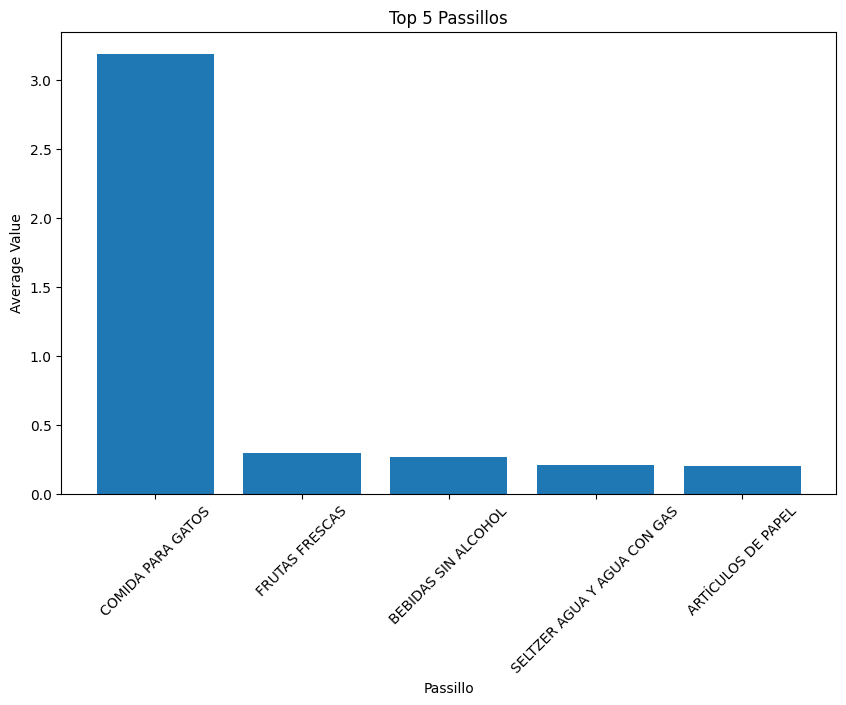

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(top_passillos.index, top_passillos.values)
plt.xlabel('Passillo')
plt.ylabel('Average Value')
plt.title('Top 5 Passillos')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
cluster_ids = cluster['id_orden'].unique()

In [ ]:
cluster_ids.shape

(4522,)

In [ ]:
cluster_orders = merged_orders[merged_orders['id_orden'].isin(cluster_ids)][['id_orden', 'id_producto']]

In [ ]:
cluster_orders

,id_orden,id_producto
0,674713,27845
1,674713,1940
9,674780,13176
10,674780,13852
11,674780,3840
...,...,...
1384597,674630,15290
1384598,674630,46979
1384599,674630,34356
1384600,674630,38739


# Initializing the graph

In [ ]:
import networkx as nx
from collections import defaultdict
import itertools
# Initialize the graph
G = nx.Graph()

# Group the orders by 'id_orden' to get all products within each transaction
grouped_orders = cluster_orders.groupby('id_orden')['id_producto'].apply(list)

# Use a dictionary to count co-occurrences
edge_count = defaultdict(int)

# Iterate through each transaction
for products in grouped_orders:
    # Create all possible pairs of products within the transaction
    for pair in itertools.combinations(products, 2):
        sorted_pair = tuple(sorted(pair))
        edge_count[sorted_pair] += 1

# Add edges and weights to the graph
for (source, target), weight in edge_count.items():
    if G.has_edge(source, target):
        G[source][target]['weight'] += weight
    else:
        G.add_edge(source, target, weight=weight)


In [ ]:
edge_list = nx.to_pandas_edgelist(G)
edge_list.head()

,source,target,weight
0,11109,49302,1
1,11109,10246,6
2,11109,49683,2
3,11109,43633,1
4,11109,13176,25


In [ ]:
"""edge_list_output_path = '/content/edges_cluster_1.csv'
edge_list.to_csv(edge_list_output_path, index=False)"""

## what are the products in there?

In [ ]:
# Extract unique product IDs from source and target columns
unique_product_ids = pd.unique(edge_list[['source', 'target']].values.ravel('K'))

# Create a DataFrame with these unique product IDs
unique_products_df = pd.DataFrame({'id_producto': unique_product_ids})

# Merge with merged_orders to get product names
product_names_df = unique_products_df.merge(merged_orders[['id_producto', 'nombre_producto']].drop_duplicates(), on='id_producto', how='left')

In [ ]:
product_names_df.head()

,id_producto,nombre_producto
0,11109,4% ORGÁNICO QUESO GRASA DE LECHE LECHE ENTERA ...
1,49302,EL YOGUR DE BULGARIA
2,10246,CORAZONES DE APIO ORGÁNICOS
3,49683,KIRBY PEPINO
4,43633,LAS SARDINAS LIGERAMENTE AHUMADO EN ACEITE DE ...


In [ ]:
"""# Save the nodes DataFrame to a CSV
nodes_output_path = '/content/nodes_cluster_1.csv'
product_names_df.to_csv(nodes_output_path, index=False)"""

## what  can we say about the graph

In [ ]:
# Print the size of the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"The graph has {num_nodes} nodes and {num_edges} edges.")

The graph has 25852 nodes and 2354461 edges.


In [ ]:
# Calculate network metrics
components = [G.subgraph(c).copy() for c in nx.connected_components(G)]

In [ ]:
diameters = [nx.diameter(comp) for comp in components]
diameter = max(diameters)
print("Diameter of the Network:", diameter)

In [ ]:
average_path_lengths = [nx.average_shortest_path_length(comp) for comp in components]
average_path_length = sum(average_path_lengths) / len(average_path_lengths)
print("Average Path Length of the Network:", average_path_length)

In [ ]:
largest_component = max(components, key=len)

In [ ]:
# Calculate the average number of items in the basket
average_items_in_basket = sum(len(list(G.neighbors(node))) for node in G.nodes) / G.number_of_nodes()

# Print network metrics
print("Average Items in the Basket:", average_items_in_basket)

In [ ]:
product_names_dict = product_names_df.set_index('id_producto')['nombre_producto'].to_dict()

## digging deep into the network analysis

In [ ]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
pagerank_centrality = nx.pagerank(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

# Create a DataFrame to store the centrality measures
centrality_df = pd.DataFrame({
    'id_producto': list(degree_centrality.keys()),
    'degree_centrality': list(degree_centrality.values()),
    'betweenness_centrality': list(betweenness_centrality.values()),
    'closeness_centrality': list(closeness_centrality.values()),
    'pagerank_centrality': list(pagerank_centrality.values()),
    'eigenvector_centrality': list(eigenvector_centrality.values())
})

In [ ]:
centrality_with_names = centrality_df.merge(product_names_df, on='id_producto', how='left')

In [ ]:
# Sort by degree centrality and print the top products
top_degree_centrality = centrality_with_names.sort_values(by='degree_centrality', ascending=False).head(10)
print("Top Products by Degree Centrality:")
print(top_degree_centrality[['nombre_producto', 'degree_centrality']])
print()

# Sort by betweenness centrality and print the top products
top_betweenness_centrality = centrality_with_names.sort_values(by='betweenness_centrality', ascending=False).head(10)
print("Top Products by Betweenness Centrality:")
print(top_betweenness_centrality[['nombre_producto', 'betweenness_centrality']])
print()

# Sort by closeness centrality and print the top products
top_closeness_centrality = centrality_with_names.sort_values(by='closeness_centrality', ascending=False).head(10)
print("Top Products by Closeness Centrality:")
print(top_closeness_centrality[['nombre_producto', 'closeness_centrality']])
print()

# Sort by pagerank centrality and print the top products
top_pagerank_centrality = centrality_with_names.sort_values(by='pagerank_centrality', ascending=False).head(10)
print("Top Products by PageRank Centrality:")
print(top_pagerank_centrality[['nombre_producto', 'pagerank_centrality']])
print()

# Sort by eigenvector centrality and print the top products
top_eigenvector_centrality = centrality_with_names.sort_values(by='eigenvector_centrality', ascending=False).head(10)
print("Top Products by Eigenvector Centrality:")
print(top_eigenvector_centrality[['nombre_producto', 'eigenvector_centrality']])
print()